In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Loading the Libraries

In [5]:
df = pd.read_csv('spam.csv',encoding="utf-8")

In [6]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
327,ham,"I'd say that's a good sign but, well, you know...",NaN,NaN,NaN
4555,ham,Gettin rdy to ship comp,NaN,NaN,NaN
315,ham,K.k:)advance happy pongal.,NaN,NaN,NaN
209,ham,Both :) i shoot big loads so get ready!,NaN,NaN,NaN
447,ham,I wont get concentration dear you know you are...,NaN,NaN,NaN


In [7]:
#removing unwanted columns and renaming the columns
df = df[["v1","v2"]]
df.rename(columns={"v1":"label","v2":"text"},inplace=True)

In [8]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
df.describe()

,label,text
count,5572,5572
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
df.duplicated().sum()

404

***data contains duplicates rows hence we need to remove them***

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.label.value_counts()

ham     4516
spam     652
Name: label, dtype: int64

# Visulaizations

<AxesSubplot:ylabel='label'>

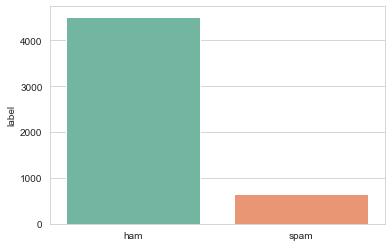

In [15]:
sns.barplot(x=df.label.value_counts().index,y=df.label.value_counts())

***Highly imblance classes in the dataset***

<AxesSubplot:xlabel='text', ylabel='Count'>

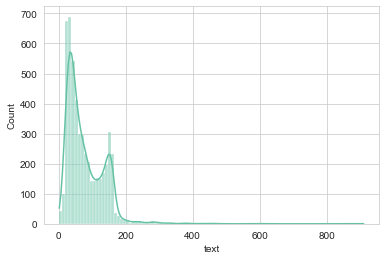

In [16]:
sns.histplot(df["text"].apply(len),bins=100,kde=True)

***Most length of Descriptions is in the range 0-300***

<AxesSubplot:title={'center':'Average Number of Sentences'}, xlabel='type', ylabel='sentences'>

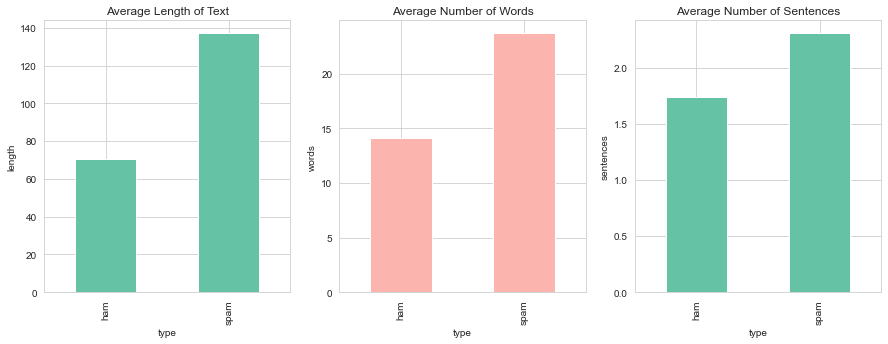

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

df.groupby("label").apply(lambda x: x["text"].apply(len).mean()).plot(
    kind="bar", ax=ax1, title="Average Length of Text",xlabel="type",ylabel="length")

df.groupby("label").apply(lambda x: x["text"].apply(lambda x: len(
    x.split())).mean()).plot(kind="bar", ax=ax2, title="Average Number of Words",xlabel="type",ylabel="words",colormap="Pastel1")

df.groupby("label").apply(lambda x: x["text"].apply(lambda x: len(x.split(
    ". "))).mean()).plot(kind="bar", ax=ax3, title="Average Number of Sentences",xlabel="type",ylabel="sentences")

***Clearly Spam avg length is nearly double of ham*** <br>
***Clearly Spam avg number of words is nearly double of ham*** <br>
***Clearly Spam avg sentence count is greater than of ham*** <br>

In [19]:
!pip install wordcloud

   -------------------------------------- 300.6/300.6 kB 885.2 kB/s eta 0:00:00


# Preprocessing

In [24]:
df["text"].sample(5)

5159                         No but the bluray player can
4174    How are you doing. How's the queen. Are you go...
1158                      Hey! There's veggie pizza... :/
4079    Sir, good morning. Hope you had a good weekend...
4533                      I have no money 4 steve mate! !
Name: text, dtype: object

In [25]:
import re
import string
from nltk.corpus import stopwords
import nltk
stopwd = stopwords.words('english')
def clean_text(text):

    text= text.lower() # Lowercasing the text
    text = re.sub('-',' ',text.lower())   # Replacing `x-x` as `x x`
    text = re.sub(r'http\S+', '', text) # Removing Links
    text = re.sub(f'[{string.punctuation}]', '', text) # Remove punctuations
    text = re.sub(r'\s+', ' ', text) # Removing unnecessary spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Removing single characters
    
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    text = " ".join([i for i in words if i not in stopwd and len(i)>2]) # Removing the stop words

    return text.strip()

In [26]:
df["clean_text"] = df["text"].apply(clean_text)

In [27]:
df.head()

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts 21st m...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


# Splitting the Data

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4134,), (1034,), (4134,), (1034,))

In [30]:
X_train.head()

3040                                 aight time want come
1663                                          mostly like
5058    free video camera phones half price line renta...
2120    argh spotty anyway thing remember research pro...
1728    per request maangalyam alaipayuthe set callert...
Name: clean_text, dtype: object

# Vectorizing

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = CountVectorizer(stop_words='english',lowercase=True)
# vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,ngram_range=(1,3),lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [32]:
X_train_vectorized.shape, X_test_vectorized.shape

((4134, 7758), (1034, 7758))

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<AxesSubplot:xlabel='0'>

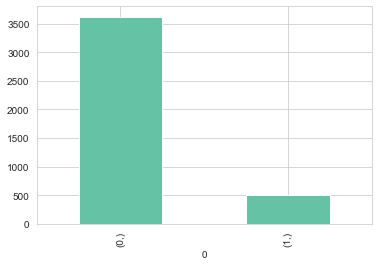

In [34]:
pd.DataFrame(y_train).value_counts().plot(kind="bar")

***Balancing both the classes using the RandomOverSampler***

In [35]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
# We will pass to it the output of TfidfVectorizer from train data
x_train_resampled, y_train_resampled = sampler.fit_resample(
    X_train_vectorized, y_train)

<AxesSubplot:xlabel='0'>

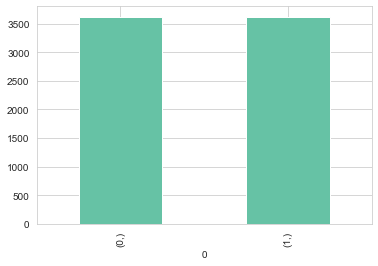

In [36]:
pd.DataFrame(y_train_resampled).value_counts().plot(kind="bar")

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score

# Modelling

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000,solver="sag",tol=0.001,max_iter=500,random_state=15)
lr.fit(x_train_resampled,y_train_resampled)

LogisticRegression(C=1000, max_iter=500, random_state=15, solver='sag',
                   tol=0.001)

In [40]:
print("Train Accuracy: ", lr.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", lr.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, lr.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, lr.predict(X_test_vectorized)))

Train Accuracy:  1.0
Test Accuracy:  0.9845261121856866
Train Precision:  1.0
Test Precision:  0.9923076923076923


In [41]:
from sklearn.naive_bayes import MultinomialNB

cnb = MultinomialNB(alpha=0.1)
cnb.fit(x_train_resampled,y_train_resampled)

MultinomialNB(alpha=0.1)

In [42]:
print("Train Accuracy: ", cnb.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", cnb.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, cnb.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, cnb.predict(X_test_vectorized)))

Train Accuracy:  0.990761169332598
Test Accuracy:  0.9632495164410058
Train Precision:  0.987400712133662
Test Precision:  0.8397435897435898


In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_resampled,y_train_resampled)

RandomForestClassifier(random_state=42)

In [44]:
print("Train Accuracy: ", rf.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", rf.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, rf.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, rf.predict(X_test_vectorized)))

Train Accuracy:  1.0
Test Accuracy:  0.9709864603481625
Train Precision:  1.0
Test Precision:  0.9913793103448276


In [45]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train_resampled,y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [46]:
print("Train Accuracy: ", dt.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", dt.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, dt.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, dt.predict(X_test_vectorized)))

Train Accuracy:  1.0
Test Accuracy:  0.9506769825918762
Train Precision:  1.0
Test Precision:  0.8079470198675497


In [47]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(x_train_resampled,y_train_resampled)

SVC(random_state=42)

In [48]:
print("Train Accuracy: ", svc.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", svc.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, svc.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, svc.predict(X_test_vectorized)))

Train Accuracy:  0.9991726420297848
Test Accuracy:  0.9796905222437138
Train Precision:  0.999723909442297
Test Precision:  0.992


In [49]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.7,max_depth=7,n_estimators=200)
xgb.fit(x_train_resampled,y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.7, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [50]:
print("Train Accuracy: ", xgb.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", xgb.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, xgb.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, xgb.predict(X_test_vectorized)))

Train Accuracy:  0.9977937120794264
Test Accuracy:  0.9758220502901354
Train Precision:  0.9988944168048646
Test Precision:  0.9612403100775194


In [53]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(x_train_resampled.toarray(),y_train_resampled)

[LightGBM] [Info] Number of positive: 3626, number of negative: 3626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 7252, number of used features: 694
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [52]:
!pip install lightgbm

   ---------------------------------------- 1.3/1.3 MB 2.7 MB/s eta 0:00:00


In [54]:
print("Train Accuracy: ", lgbm.score(x_train_resampled.toarray(), y_train_resampled))
print("Test Accuracy: ", lgbm.score(X_test_vectorized.toarray(), y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, lgbm.predict(x_train_resampled.toarray())))
print("Test Precision: ", precision_score(y_test, lgbm.predict(X_test_vectorized.toarray())))

Train Accuracy:  0.9933811362382791
Test Accuracy:  0.9709864603481625
Train Precision:  0.9966685174902832
Test Precision:  0.9014084507042254


# Scores

In [55]:
y_pred_train_lr = lr.predict(x_train_resampled)
y_pred_test_lr = lr.predict(X_test_vectorized)

y_pred_train_cnb = cnb.predict(x_train_resampled)
y_pred_test_cnb = cnb.predict(X_test_vectorized)

y_pred_train_rf = rf.predict(x_train_resampled)
y_pred_test_rf = rf.predict(X_test_vectorized)

y_pred_train_dt = dt.predict(x_train_resampled)
y_pred_test_dt = dt.predict(X_test_vectorized)

y_pred_train_svc = svc.predict(x_train_resampled)
y_pred_test_svc = svc.predict(X_test_vectorized)

y_pred_train_xgb = xgb.predict(x_train_resampled)
y_pred_test_xgb = xgb.predict(X_test_vectorized)

y_pred_train_lgbm = lgbm.predict(x_train_resampled.toarray())
y_pred_test_lgbm = lgbm.predict(X_test_vectorized.toarray())

In [56]:
from sklearn.metrics import roc_auc_score,roc_curve

modelsdict = {"LR":lr,"CNB":cnb,"RF":rf,"DT":dt,"SVC":svc,"XGB":xgb,"LGBM":lgbm}

scoresdict = {}

for key,value in modelsdict.items():

    Train_ACC=accuracy_score(y_train_resampled,value.predict(x_train_resampled.toarray()))
    Train_Prec=precision_score(y_train_resampled,value.predict(x_train_resampled.toarray()))
    Test_ACC=accuracy_score(y_test,value.predict(X_test_vectorized.toarray()))
    Test_Prec=precision_score(y_test,value.predict(X_test_vectorized.toarray()))

    scoresdict[key] = [Train_ACC,Train_Prec,Test_ACC,Test_Prec]

scoresdf = pd.DataFrame(scoresdict,index=["Train_ACC","Train_Prec","Test_ACC","Test_Prec"]).T

In [57]:
scoresdf.sort_values(by="Test_ACC",ascending=False)

,Train_ACC,Train_Prec,Test_ACC,Test_Prec
LR,1.000000,1.000000,0.984526,0.992308
SVC,0.999173,0.999724,0.979691,0.992000
RF,1.000000,1.000000,0.970986,0.991379
LGBM,0.993381,0.996669,0.970986,0.901408
CNB,0.990761,0.987401,0.963250,0.839744
DT,1.000000,1.000000,0.950677,0.807947
XGB,0.500000,0.500000,0.139265,0.139265


In [58]:
scoresdf.sort_values(by="Test_Prec",ascending=False)

,Train_ACC,Train_Prec,Test_ACC,Test_Prec
LR,1.000000,1.000000,0.984526,0.992308
SVC,0.999173,0.999724,0.979691,0.992000
RF,1.000000,1.000000,0.970986,0.991379
LGBM,0.993381,0.996669,0.970986,0.901408
CNB,0.990761,0.987401,0.963250,0.839744
DT,1.000000,1.000000,0.950677,0.807947
XGB,0.500000,0.500000,0.139265,0.139265


<AxesSubplot:title={'center':'Accuracy and Precision Scores'}, xlabel='Models', ylabel='Accuracy'>

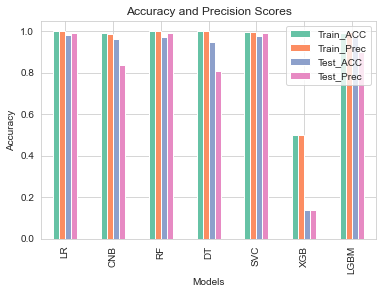

In [59]:
scoresdf.plot(kind="bar",title="Accuracy and Precision Scores",xlabel="Models",ylabel="Accuracy")

***Roc Curve***

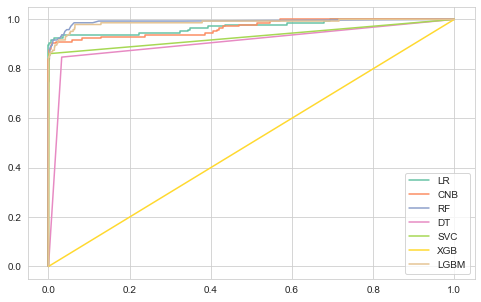

In [60]:
plt.figure(figsize=(8,5))

for key,value in modelsdict.items():
    try:
        fpr,tpr,thresholds = roc_curve(y_test,value.predict_proba(X_test_vectorized.toarray())[:,1])
    except:
        fpr,tpr,thresholds = roc_curve(y_test,value.predict(X_test_vectorized.toarray()))
    plt.plot(fpr,tpr,label=key)
plt.legend()

Text(0.5, 1.0, 'LightGBM')

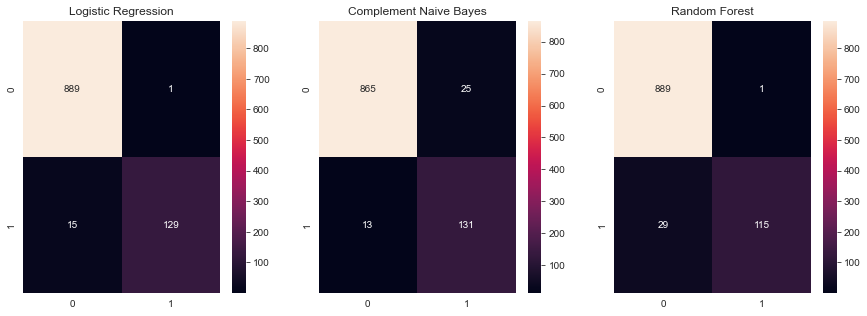

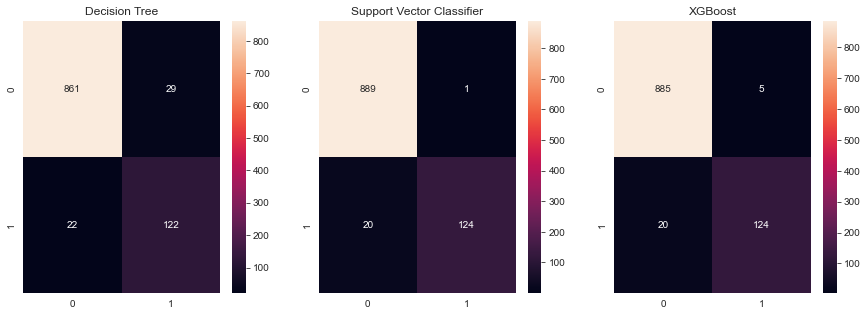

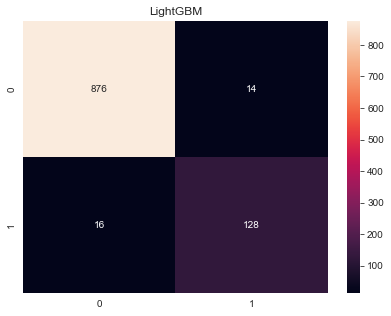

In [61]:
cnf_lr = confusion_matrix(y_test,y_pred_test_lr)
cnf_cnb = confusion_matrix(y_test,y_pred_test_cnb)
cnf_rf = confusion_matrix(y_test,y_pred_test_rf)
cnf_dt = confusion_matrix(y_test,y_pred_test_dt)
cnf_svc = confusion_matrix(y_test,y_pred_test_svc)
cnf_xgb = confusion_matrix(y_test,y_pred_test_xgb)
cnf_lgbm = confusion_matrix(y_test,y_pred_test_lgbm)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.heatmap(cnf_lr,annot=True,fmt="d")
plt.title("Logistic Regression")
plt.subplot(1,3,2)
sns.heatmap(cnf_cnb,annot=True,fmt="d")
plt.title("Complement Naive Bayes")
plt.subplot(1,3,3)
sns.heatmap(cnf_rf,annot=True,fmt="d")
plt.title("Random Forest")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.heatmap(cnf_dt,annot=True,fmt="d")
plt.title("Decision Tree")
plt.subplot(1,3,2)
sns.heatmap(cnf_svc,annot=True,fmt="d")
plt.title("Support Vector Classifier")
plt.subplot(1,3,3)
sns.heatmap(cnf_xgb,annot=True,fmt="d")
plt.title("XGBoost")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(cnf_lgbm,annot=True,fmt="d")
plt.title("LightGBM")

# Test

In [62]:
input1 =''' Hi, I am a student of Charusat University. I am writing this mail to inform you that I have been selected for the internship at Google. I am very excited to work with you.'''
input2 = '''You have won a lottery of 1 million dollars. Please send your bank details to claim the prize.'''
input = clean_text(input1)
# input = clean_text(input2)
print(input)
input = vectorizer.transform([input])
print(le.inverse_transform(rf.predict(input)))

student charusat university writing mail inform selected internship google excited work
['ham']


In [63]:
!pip install prereqs

ERROR: Could not find a version that satisfies the requirement prereqs (from versions: none)
ERROR: No matching distribution found for prereqs
